## classification

In [1]:
import sys
sys.path.append('eucalc_directory')
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from numpy import genfromtxt
from sklearn.decomposition import PCA

# Path to the folder containing the CSV files
datafolder = "Old_Young_Comparison"

all_files = os.listdir(datafolder)

# Get all CSV filenames in the folder
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]


# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

In [3]:
import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100, yinterval=(-1., 1.), ypoints=100):
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints
        self.image = self.compute(img, k, xinterval, xpoints, yinterval, ypoints)
        self.nm = nm
    def compute(self, img, k, xinterval, xpoints, yinterval, ypoints):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1


def compute_ExIm(names, datafolder, k=480, xinterval=(-1.5, 1.5), xpoints=300, yinterval=(-450., 50.), ypoints=500):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        # Now, compute the ECT image using the new array
        ect = EctImg(nm, img_array, k, xinterval, xpoints, yinterval, ypoints)
        exim = ect.compute(img_array, k, xinterval, xpoints, yinterval, ypoints)
        ExImage.append(exim)

    return ExImage

exims = compute_ExIm(names_k8, datafolder,k=360, xinterval=(-1.5, 1.5), xpoints=750, yinterval=(-20, 60), ypoints=80)

In [4]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    """
    Compute the Wasserstein distance between two empirical measures,
    each represented as a k x N array (each row is a function sampled at N points),
    incorporating the delta_x factor for uniformly sampled points.

    Parameters:
        empirical1 : np.array of shape (k, N)
            The first set of functions.
        empirical2 : np.array of shape (k, N)
            The second set of functions.
        p : float, default 2
            The order of the norm (p=2 for L2, p=1 for L1).
        delta_x : float, default 1.0
            The spacing between sample points, e.g.,
            (x_max - x_min) / (N - 1).

    Returns:
        float
            The computed Wasserstein distance.
    """
    # Compute the cost matrix using the Minkowski metric.
    # cdist returns (sum_i |f_i - g_i|^p)^(1/p), so we multiply by (delta_x)^(1/p)
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    
    # Solve the assignment problem to obtain the best matching.
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Compute the average p-th power cost for the matched pairs.
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    
    # Return the p-th root of the average cost.
    return avg_cost_p ** (1.0 / p)

def compute_distance_matrix(measures, p=2, delta_x=1.0):
    """
    Given a list 'measures' of empirical measures (each a k x N array),
    compute the pairwise Wasserstein distance matrix.

    Parameters:
        measures : list of np.array
            Each element is an empirical measure (k functions sampled at N points).
        p : float, default 2
            The order of the norm.
        delta_x : float, default 1.0
            The spacing between the sample points.

    Returns:
        np.array
            An n x n symmetric matrix of Wasserstein distances.
    """
    n = len(measures)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    return distance_matrix

def construct_rbf_kernel(distance_matrix, sigma=None):
    """
    Construct an RBF kernel from the distance matrix.
    If sigma is not provided, the median of the distances is used.

    Parameters:
        distance_matrix : np.array
            The matrix of pairwise Wasserstein distances.
        sigma : float or None, default None
            The RBF kernel width parameter.

    Returns:
        np.array
            The RBF kernel matrix.
    """
    if sigma is None:
        sigma = np.median(distance_matrix)
    kernel_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))
    return kernel_matrix

# Example usage:
# Suppose your functions are sampled on an interval xinterval = (x_min, x_max)
# and you have xpoints samples per function.
x_min, x_max = -1.5, 1.5
xpoints = 300
delta_x = (x_max - x_min) / (xpoints - 1)

# exims is assumed to be a list where each element is a k x N array.
p = 2  # L2 norm (set to 1 for L1)
distance_matrix = compute_distance_matrix(exims, p=p, delta_x=delta_x)
kernel_matrix = construct_rbf_kernel(distance_matrix)


In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

def extract_age(name):
    return name[0]

# Assume names_k8 and kernel_matrix are already defined.
# kernel_matrix is assumed to be an n x n matrix computed from your Wasserstein distances.
ages_k8 = [extract_age(name) for name in names_k8]
y = np.array(ages_k8)
unique_ages = np.unique(y)
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: label 1 if sample belongs to the target age, 0 otherwise.
binary_labels = np.where(y == age, 1, 0)

# For a precomputed kernel, X is the kernel matrix.
X_kernel = kernel_matrix  # n x n matrix for all samples

# Define a parameter grid for SVM with precomputed kernel.
# We only tune C since our kernel is fixed.
param_grid = {
    'C': [0.1, 1, 10, 100]
}

# Perform Grid Search with 3-fold cross-validation.
grid_search = GridSearchCV(
    estimator=SVC(kernel='precomputed', random_state=40),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_kernel, binary_labels)

# Extract the best parameters.
best_params = grid_search.best_params_
print(f"Best parameters for age group {age}: {best_params}")

scores = []
num_trials = 50
n_samples = X_kernel.shape[0]

for trial in range(num_trials):
    # Generate train-test split indices.
    indices = np.arange(n_samples)
    train_idx, test_idx = train_test_split(
        indices, test_size=0.2, random_state=40 + trial
    )
    
    # For precomputed kernels, training data is the submatrix with rows and columns corresponding to training indices.
    # Test data is formed by rows for test indices and columns for training indices.
    X_train = X_kernel[np.ix_(train_idx, train_idx)]
    X_test = X_kernel[np.ix_(test_idx, train_idx)]
    y_train = binary_labels[train_idx]
    y_test = binary_labels[test_idx]
    
    # Initialize and train the SVM classifier using the best found parameter C.
    svm_classifier = SVC(kernel='precomputed', random_state=40, **best_params)
    svm_classifier.fit(X_train, y_train)
    score = svm_classifier.score(X_test, y_test)
    scores.append(score)

print(f'Average accuracy for age {age} is {np.mean(scores)}')

Processing age group: O
Best parameters for age group O: {'C': 10}
Average accuracy for age O is 0.7285714285714286


### k14

In [8]:
exims = compute_ExIm(names_k14, datafolder,k=360, xinterval=(-1.5, 1.5), xpoints=750, yinterval=(-20, 60), ypoints=80)
p = 2  # L2 norm (set to 1 for L1)
distance_matrix = compute_distance_matrix(exims, p=p, delta_x=delta_x)
kernel_matrix = construct_rbf_kernel(distance_matrix)

In [9]:
import shap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

def extract_age(name):
    return name[0]

# Assume names_k8 and kernel_matrix are already defined.
# kernel_matrix is assumed to be an n x n matrix computed from your Wasserstein distances.
ages_k14 = [extract_age(name) for name in names_k14]
y = np.array(ages_k14)
unique_ages = np.unique(y)
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: label 1 if sample belongs to the target age, 0 otherwise.
binary_labels = np.where(y == age, 1, 0)

# For a precomputed kernel, X is the kernel matrix.
X_kernel = kernel_matrix  # n x n matrix for all samples

# Define a parameter grid for SVM with precomputed kernel.
# We only tune C since our kernel is fixed.
param_grid = {
    'C': [0.1, 1, 10, 100]
}

# Perform Grid Search with 3-fold cross-validation.
grid_search = GridSearchCV(
    estimator=SVC(kernel='precomputed', random_state=40),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_kernel, binary_labels)

# Extract the best parameters.
best_params = grid_search.best_params_
print(f"Best parameters for age group {age}: {best_params}")

scores = []
num_trials = 50
n_samples = X_kernel.shape[0]

for trial in range(num_trials):
    # Generate train-test split indices.
    indices = np.arange(n_samples)
    train_idx, test_idx = train_test_split(
        indices, test_size=0.2, random_state=40 + trial
    )
    
    # For precomputed kernels, training data is the submatrix with rows and columns corresponding to training indices.
    # Test data is formed by rows for test indices and columns for training indices.
    X_train = X_kernel[np.ix_(train_idx, train_idx)]
    X_test = X_kernel[np.ix_(test_idx, train_idx)]
    y_train = binary_labels[train_idx]
    y_test = binary_labels[test_idx]
    
    # Initialize and train the SVM classifier using the best found parameter C.
    svm_classifier = SVC(kernel='precomputed', random_state=40, **best_params)
    svm_classifier.fit(X_train, y_train)
    score = svm_classifier.score(X_test, y_test)
    scores.append(score)

print(f'Average accuracy for age {age} is {np.mean(scores)}')


Processing age group: O


/Users/hyang/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best parameters for age group O: {'C': 0.1}
Average accuracy for age O is 0.7200000000000002


## distinguishing two shapes

In [37]:
from scipy.stats import ks_2samp
import numpy as np
import random



def compute_measure(img, k=360, xinterval=(-1.5, 1.5), xpoints=75):
    cplx = ec.EmbeddedComplex(img)
    cplx.preproc_ect()
    thetas = np.random.uniform(0, 2 * np.pi, k + 1)
    ect1 = np.empty((k, xpoints), dtype=float)
    for i in range(k):
        theta = thetas[i]
        direction = np.array((np.sin(theta), np.cos(theta)))
        ect_dir = cplx.compute_euler_characteristic_transform(direction)
        T = np.linspace(xinterval[0], xinterval[1], xpoints)
        ect1[i] = [ect_dir.evaluate(t) for t in T]
    return ect1

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def compute_distance_distribution(shape1, shape2, k=360, xinterval=(-1.5, 1.5), xpoints=75, n=100):
    distribution = np.empty(n, dtype=float)
    for i in range(n):
        empirical1 = compute_measure(shape1, k, xinterval, xpoints)
        empirical2 = compute_measure(shape2, k, xinterval, xpoints)
        distribution[i] = wasserstein_distance(empirical1, empirical2)
    return distribution


test_shape1 = np.array(Image.open(os.path.join(datafolder, names_k8[0])))
test_shape2 = np.array(Image.open(os.path.join(datafolder, names_k8[0])))

distribution1 = compute_distance_distribution(test_shape1, test_shape1)
distribution2 = compute_distance_distribution(test_shape1, test_shape2)


ks_statistic, p_value = ks_2samp(distribution1, distribution2)

print("KS statistic:", ks_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: the distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: there is no significant difference between the distributions.")


KS statistic: 0.042
p-value: 0.7704365372945415
Fail to reject the null hypothesis: there is no significant difference between the distributions.


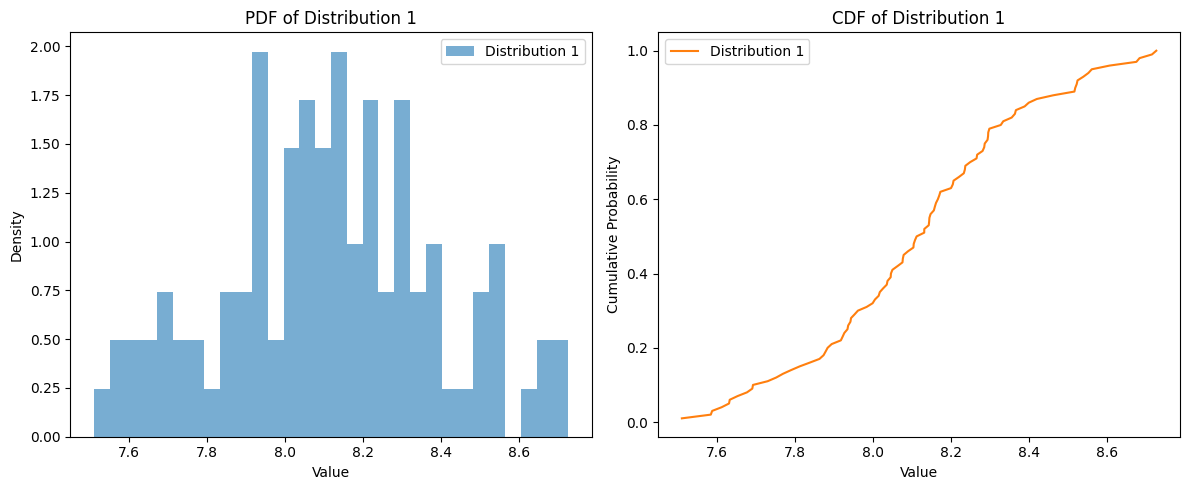

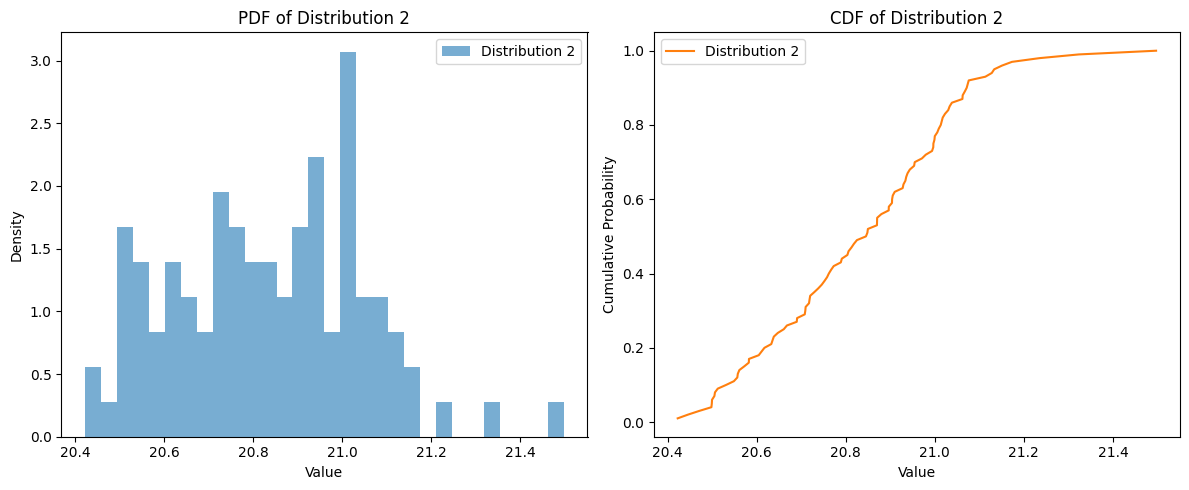

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pdf_cdf(distribution, label, bins=30):
    """
    Plot the PDF and CDF of an empirical distribution.
    
    Parameters:
        distribution : np.array
            Array of samples from the empirical distribution.
        label : str
            Label for the distribution (for plot legends and titles).
        bins : int, default 30
            Number of bins for the histogram (PDF estimation).
    """
    # Compute the PDF using a histogram
    pdf_values, bin_edges = np.histogram(distribution, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    
    # Compute the empirical CDF using the sorted data
    sorted_data = np.sort(distribution)
    cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Create subplots for PDF and CDF side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot PDF
    ax[0].bar(bin_centers, pdf_values, width=(bin_edges[1]-bin_edges[0]), alpha=0.6, label=label)
    ax[0].set_title(f'PDF of {label}')
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Density')
    ax[0].legend()
    
    # Plot CDF
    ax[1].plot(sorted_data, cdf_values, label=label, color='C1')
    ax[1].set_title(f'CDF of {label}')
    ax[1].set_xlabel('Value')
    ax[1].set_ylabel('Cumulative Probability')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume distribution1 and distribution2 have been computed already.
plot_pdf_cdf(distribution1, 'Distribution 1')
plot_pdf_cdf(distribution2, 'Distribution 2')



In [54]:
import os
import numpy as np
from PIL import Image
from scipy.stats import ks_2samp
from joblib import Parallel, delayed

def process_pair(i, j):
    """
    Process a pair of images indexed by i and j.
    Returns a tuple (i, j, test_result, p_value) where test_result is True if the p-value > 0.05.
    """
    print(f"Processing pair ({i}, {j})")
    # Load the images for the given indices
    test_shape1 = np.array(Image.open(os.path.join(datafolder, names_k8[i])))
    test_shape2 = np.array(Image.open(os.path.join(datafolder, names_k8[j])))
    
    # Compute the empirical distributions
    distribution1 = compute_distance_distribution(test_shape1, test_shape1, k=360, xinterval=(-1.5,1.5), xpoints=300, n=200)
    distribution2 = compute_distance_distribution(test_shape1, test_shape2, k=360, xinterval=(-1.5,1.5), xpoints=300, n=200)
    
    # Perform the Kolmogorov-Smirnov test
    ks_statistic, p_value = ks_2samp(distribution1, distribution2)
    
    # Return True if the p-value indicates the distributions are not significantly different
    return i, j, (p_value > 0.05), p_value

# Number of images
n = len(names_k8)
result = np.empty((n, n), dtype=bool)
p_value_matrix = np.empty((n, n), dtype=float)

# Create a list of index pairs (only upper triangle including the diagonal)
pairs = [(i, j) for i in range(n) for j in range(i, n)]

# Process the pairs in parallel using all available cores
outputs = Parallel(n_jobs=-1)(delayed(process_pair)(i, j) for i, j in pairs)

# Fill in the symmetric result matrices
for i, j, test_result, p_value in outputs:
    result[i, j] = test_result
    result[j, i] = test_result  # mirror the result since the test is symmetric
    p_value_matrix[i, j] = p_value
    p_value_matrix[j, i] = p_value  # mirror the p-value matrix

# Now 'result' contains the symmetric boolean matrix of KS test outcomes,
# and 'p_value_matrix' contains the symmetric matrix of p-values from the KS test.


Processing pair (0, 0)
Processing pair (0, 1)
Processing pair (0, 2)
Processing pair (0, 3)
Processing pair (0, 4)
Processing pair (0, 5)
Processing pair (0, 6)
Processing pair (0, 7)
Processing pair (0, 8)
Processing pair (0, 9)
Processing pair (0, 10)
Processing pair (0, 11)
Processing pair (0, 12)
Processing pair (0, 13)
Processing pair (0, 14)
Processing pair (0, 15)
Processing pair (0, 16)
Processing pair (0, 17)
Processing pair (0, 18)
Processing pair (0, 19)
Processing pair (0, 20)
Processing pair (0, 21)
Processing pair (0, 22)
Processing pair (0, 23)
Processing pair (0, 24)
Processing pair (0, 25)
Processing pair (0, 26)
Processing pair (0, 27)
Processing pair (0, 28)
Processing pair (0, 29)
Processing pair (0, 30)
Processing pair (0, 31)
Processing pair (0, 32)
Processing pair (0, 33)
Processing pair (0, 34)
Processing pair (0, 35)
Processing pair (0, 36)
Processing pair (0, 37)
Processing pair (0, 38)
Processing pair (0, 39)
Processing pair (0, 40)
Processing pair (0, 41)
Pr

Loaded stored result_bool and result_bool_m arrays.


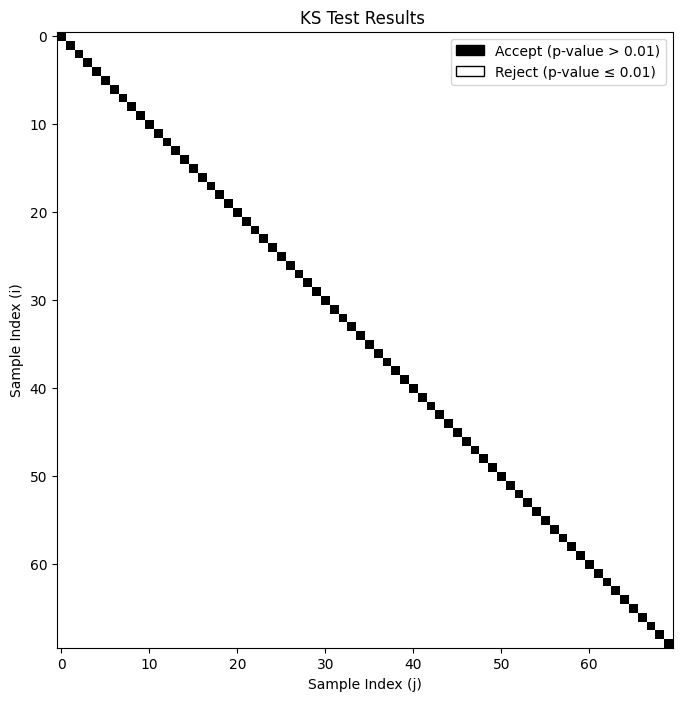

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Filenames for stored results (now storing boolean arrays directly)
result_bool_file = 'result_bool.npy'
result_bool_m_file = 'result_bool_m.npy'

# Check if the saved boolean arrays exist
if os.path.exists(result_bool_file) and os.path.exists(result_bool_m_file):
    # Load the stored arrays as booleans
    result_bool = np.load(result_bool_file)
    result_bool_m = np.load(result_bool_m_file)
    print("Loaded stored result_bool and result_bool_m arrays.")
else:
    # Otherwise, compute them (assuming that `outputs` and `result` are already available)
    
    # Here, we assume 'result' is already computed as a boolean array.
    # Create the result_m matrix and fill it based on a p-value threshold of 0.01
    result_m = np.empty((n, n), dtype=bool)
    for i, j, test_result, p_value in outputs:
        test = p_value > 0.01
        result_m[i, j] = test
        result_m[j, i] = test

    # Store the boolean arrays directly, without converting to integers
    result_bool = result  # assuming 'result' is boolean
    result_bool_m = result_m
    
    # Save the arrays to disk
    np.save(result_bool_file, result_bool)
    np.save(result_bool_m_file, result_bool_m)
    print("Computed and saved result_bool and result_bool_m arrays.")

# Plot the boolean image for result_bool_m using a binary colormap
plt.figure(figsize=(10, 8))
plt.imshow(result_bool_m, interpolation='nearest', cmap='binary')
plt.title("KS Test Results ")
plt.xlabel("Sample Index (j)")
plt.ylabel("Sample Index (i)")

# Create custom legend patches:
# 'True' values are mapped to black (Accept, i.e. p-value > 0.01)
# 'False' values are mapped to white (Reject, i.e. p-value <= 0.01)
patch_accept = mpatches.Patch(color='black', label='Accept (p-value > 0.01)')
patch_reject = mpatches.Patch(facecolor='white', edgecolor='black', label='Reject (p-value ≤ 0.01)')

plt.legend(handles=[patch_accept, patch_reject], loc='upper right')
plt.show()


Loaded stored result_int and result_int_m arrays.


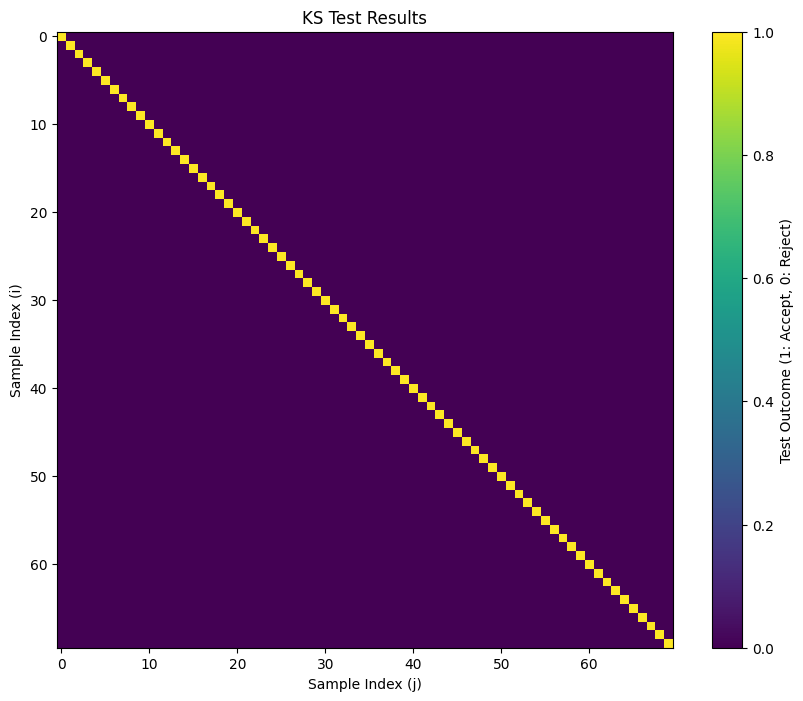

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Filenames for stored results
result_int_file = 'result_int.npy'
result_int_m_file = 'result_int_m.npy'

# Check if the saved arrays exist
if os.path.exists(result_int_file) and os.path.exists(result_int_m_file):
    # Load the stored arrays
    result_int = np.load(result_int_file)
    result_int_m = np.load(result_int_m_file)
    print("Loaded stored result_int and result_int_m arrays.")
else:
    # Otherwise, compute them (assuming that `outputs` and `result` are already available)
    
    # Create the result_m matrix and fill it based on p-value threshold 0.01
    result_m = np.empty((n, n), dtype=bool)
    for i, j, test_result, p_value in outputs:
        result_m[i, j] = p_value > 0.01
        result_m[j, i] = p_value > 0.01

    # Convert boolean matrices to integers
    result_int = result.astype(int)
    result_int_m = result_m.astype(int)
    
    # Save the arrays to disk
    np.save(result_int_file, result_int)
    np.save(result_int_m_file, result_int_m)
    print("Computed and saved result_int and result_int_m arrays.")

# # Plot the first image for result_int
# plt.figure(figsize=(10, 8))
# plt.imshow(result_int, interpolation='nearest', cmap='viridis')
# plt.title("KS Test Results\n(1: p-value > 0.05, 0: p-value <= 0.05)")
# plt.xlabel("Sample Index (j)")
# plt.ylabel("Sample Index (i)")
# cbar = plt.colorbar()
# cbar.set_label("Test Outcome (1: Accept, 0: Reject)")
# plt.show()

# Plot the second image for result_int_m
plt.figure(figsize=(10, 8))
plt.imshow(result_int_m, interpolation='nearest', cmap='viridis')
plt.title("KS Test Results")
plt.xlabel("Sample Index (j)")
plt.ylabel("Sample Index (i)")
cbar = plt.colorbar()
cbar.set_label("Test Outcome (1: Accept, 0: Reject)")
plt.show()


In [53]:
import os
import numpy as np
from PIL import Image
from scipy.stats import ks_2samp
from joblib import Parallel, delayed

def process_pair(i, j):
    """
    Process a pair of images indexed by i and j.
    Returns a tuple (i, j, test_result, p_value) where test_result is True if the p-value > 0.05.
    """
    print(f"Processing pair ({i}, {j})")
    # Load the images for the given indices
    test_shape1 = np.array(Image.open(os.path.join(datafolder, names_k14[i])))
    test_shape2 = np.array(Image.open(os.path.join(datafolder, names_k14[j])))
    
    # Compute the empirical distributions
    distribution1 = compute_distance_distribution(test_shape1, test_shape1, k=1000, xinterval=(-1.5,1.5), xpoints=300, n=50)
    distribution2 = compute_distance_distribution(test_shape1, test_shape2, k=1000, xinterval=(-1.5,1.5), xpoints=300, n=50)
    
    # Perform the Kolmogorov-Smirnov test
    _, p_value = ks_2samp(distribution1, distribution2)
    
    # Return True if the p-value indicates the distributions are not significantly different
    return i, j, (p_value > 0.05), p_value

# Number of images
n = len(names_k14)
result_k14 = np.empty((n, n), dtype=bool)
p_value_matrix_k14 = np.empty((n, n), dtype=float)

# Create a list of index pairs (only upper triangle including the diagonal)
pairs = [(i, j) for i in range(n) for j in range(i, n)]

# Process the pairs in parallel using all available cores
outputs = Parallel(n_jobs=-1)(delayed(process_pair)(i, j) for i, j in pairs)

# Fill in the symmetric result matrices
for i, j, test_result, p_value in outputs:
    result_k14[i, j] = test_result
    result_k14[j, i] = test_result  
    p_value_matrix_k14[i, j] = p_value
    p_value_matrix_k14[j, i] = p_value 


Processing pair (0, 0)
Processing pair (0, 4)
Processing pair (0, 3)
Processing pair (0, 1)
Processing pair (0, 2)
Processing pair (0, 6)
Processing pair (0, 7)
Processing pair (0, 5)
Processing pair (0, 8)
Processing pair (0, 9)
Processing pair (0, 11)
Processing pair (0, 10)
Processing pair (0, 12)
Processing pair (0, 13)
Processing pair (0, 14)
Processing pair (0, 15)
Processing pair (0, 16)
Processing pair (0, 17)
Processing pair (0, 18)
Processing pair (0, 19)
Processing pair (0, 20)
Processing pair (0, 21)
Processing pair (0, 22)
Processing pair (0, 23)
Processing pair (0, 24)
Processing pair (0, 25)
Processing pair (0, 26)
Processing pair (0, 27)
Processing pair (0, 28)
Processing pair (0, 29)
Processing pair (0, 30)
Processing pair (0, 31)
Processing pair (0, 32)
Processing pair (0, 33)
Processing pair (0, 34)
Processing pair (0, 35)
Processing pair (0, 36)
Processing pair (0, 37)
Processing pair (0, 38)
Processing pair (0, 39)
Processing pair (0, 40)
Processing pair (0, 41)
Pr

Loaded stored result_int and result_int_m arrays.


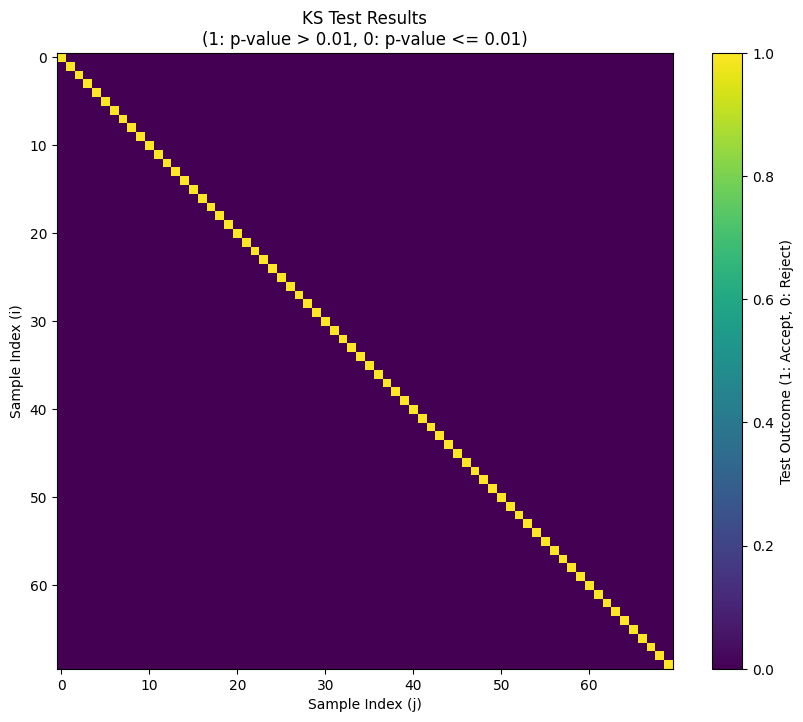

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Filenames for stored results
result_int_file_k14 = 'result_int_k14.npy'
result_int_m_file_k14 = 'result_int_m_k14.npy'

# Check if the saved arrays exist
if os.path.exists(result_int_file_k14) and os.path.exists(result_int_m_file_k14):
    # Load the stored arrays
    result_int_k14 = np.load(result_int_file_k14)
    result_int_m_k14 = np.load(result_int_m_file_k14)
    print("Loaded stored result_int and result_int_m arrays.")
else:
    # Otherwise, compute them (assuming that `outputs` and `result` are already available)
    
    # Create the result_m matrix and fill it based on p-value threshold 0.01
    result_m_k14 = np.empty((n, n), dtype=bool)
    for i, j, test_result, p_value in outputs:
        result_m_k14[i, j] = p_value > 0.05
        result_m_k14[j, i] = p_value > 0.01

    # Convert boolean matrices to integers
    result_int_k14 = result_k14.astype(int)
    result_int_m_k14 = result_m_k14.astype(int)
    
    # Save the arrays to disk
    np.save(result_int_file_k14, result_int_k14)
    np.save(result_int_m_file_k14, result_int_m_k14)
    print("Computed and saved result_int and result_int_m arrays.")

# # Plot the first image for result_int
# plt.figure(figsize=(10, 8))
# plt.imshow(result_int_k14, interpolation='nearest', cmap='viridis')
# plt.title("KS Test Results\n(1: p-value > 0.05, 0: p-value <= 0.05)")
# plt.xlabel("Sample Index (j)")
# plt.ylabel("Sample Index (i)")
# cbar = plt.colorbar()
# cbar.set_label("Test Outcome (1: Accept, 0: Reject)")
# plt.show()

# Plot the second image for result_int_m
plt.figure(figsize=(10, 8))
plt.imshow(result_int_m_k14, interpolation='nearest', cmap='viridis')
plt.title("KS Test Results\n(1: p-value > 0.01, 0: p-value <= 0.01)")
plt.xlabel("Sample Index (j)")
plt.ylabel("Sample Index (i)")
cbar = plt.colorbar()
cbar.set_label("Test Outcome (1: Accept, 0: Reject)")
plt.show()


In [ ]:
def colour_flipping(image, percentage, n):
    rows, cols = image.shape
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])
                if np.sum(surrounding_entries) >=2 and image[i,j] == False:
                    flippables.append((i,j))
        #randomly flip 10% of the flippables
        num_flips = int(len(flippables)*percentage)
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])        
                if np.sum(surrounding_entries) ==3 and image[i,j] == True:
                    flippables.append((i,j))
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    return image

test_shape2 = np.array(colour_flipping(test_shape1, 0.3, 5))